# Face Mask Detection Model Using PyTorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install --upgrade albumentations

     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 
     |████████████████████████████████| 952kB 46.2MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


### Import Libraries

In [ ]:
# Nedded Libraries

# PyTorch
import torch 
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A

# OpenCV
import cv2
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

# Image Plots
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Data managements
import numpy as np
import pandas as pd

# File interpretation
import os
import xml.etree.ElementTree as ET
import random

# Others
import time

### Find Annotation Files

In [ ]:
# Annotations directory path
ann_directory = '/content/drive/MyDrive/FaceMaskDetection/annotations'

# List directory
ann_files = os.listdir(ann_directory)

### Find Image Files

In [ ]:
# Image directory path
img_directory = '/content/drive/MyDrive/FaceMaskDetection/images'

# List directory
img_files = os.listdir(img_directory)

### Interpreting Annotations

First, some auxiliary functions are defined:

In [ ]:
def draw_bounding_boxes(img_tensor, bboxes):
  # OBSOLETE
    """Draws bounding boxes in given images.

        Args:
          img:
            Image in tensor format.
          bboxes:
            list of lists with bounding boxes coordinates (xmin, ymin, xmax, ymax)

        Returns:
          None
        """
    
    img = torchvision.transforms.ToPILImage()(img_tensor)
    bboxes = bboxes.numpy()
    
    # fetching the dimensions
    wid, hgt = img.size
    print(str(wid) + "x" + str(hgt))

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(img)

    for coordinates in bboxes:
        x = coordinates[0]
        y = coordinates[1]
        width = coordinates[2] - coordinates[0]
        height = coordinates[3] - coordinates[1]

        # Create Rectangle patches and add the patches to the axes
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none', fill=False)
        ax.add_patch(rect)

        # Show cropped bb
        # image_croped = img.crop((x, y, x+width, y+height))
        # fig = plt.figure()
        # plt.imshow(image_croped)

    plt.show(img)

In [ ]:
def draw_bounding_boxes_testing(img_tensor, target=None, prediction=None):
    """Draws bounding boxes in given images. Displays them

        Inputs:
          img:
            Image in tensor format.
          target:
            target dictionary containing bboxes list wit format -> [xmin, ymin, xmax, ymax]

        Returns:
          None
        """
    
    img = torchvision.transforms.ToPILImage()(img_tensor)

    # fetching the dimensions
    wid, hgt = img.size
    print(str(wid) + "x" + str(hgt))

    # Img to draw in
    draw = ImageDraw.Draw(img)

    if target:
      target_bboxes = target['boxes'].numpy().tolist()
      target_labels = decode_labels(target['labels'].numpy())
      
      

      for i in range(len(target_bboxes)):
          # Create Rectangle patches and add the patches to the axes
          draw.rectangle(target_bboxes[i], fill=None, outline='green', width=1)
          draw.text(target_bboxes[i][:2], target_labels[i], fill='green', font=None, anchor=None, spacing=4, align='left', direction=None, features=None, language=None, stroke_width=0, stroke_fill=None, embedded_color=False)

    if prediction:
      prediction_bboxes = prediction['boxes'].detach().cpu().numpy().tolist()
      prediction_labels = decode_labels(prediction['labels'].detach().cpu().numpy())
      for i in range(len(prediction_bboxes)):
          # Create Rectangle patches and add the patches to the axes
          draw.rectangle(prediction_bboxes[i], fill=None, outline='red', width=1)
          draw.text(prediction_bboxes[i][:2], prediction_labels[i], fill='red', font=None, anchor=None, spacing=4, align='left', direction=None, features=None, language=None, stroke_width=0, stroke_fill=None, embedded_color=False)


    display(img)

In [ ]:
def encoded_labels(lst_labels):
    """Encodes label classes from string to integers.

        Labels are encoded accordingly:
            - with_mask => 1
            - mask_weared_incorrect => 2
            - without_mask => 3

            Args:
              lst_labels:
                A list with classes in string format (e.g. ['with_mask', 'mask_weared_incorrect'...]).

            Returns:
              encoded:
                A list with integers that represent each class.
            """

    encoded=[]
    for label in lst_labels:
        if label == "with_mask":
            code = 1
        elif label == "mask_weared_incorrect":
            code = 2
        elif label == "without_mask":
            code = 3
        else:
            code = 0
        encoded.append(code)
    return encoded

In [ ]:
def decode_labels(lst_labels):
    """Decode label classes from integers to strings.

        Labels are encoded accordingly:
            - with_mask => 1
            - mask_weared_incorrect => 2
            - without_mask => 3

            Args:
              lst_labels:
                A list with classes in integer format (e.g. [1, 2, ...]).

            Returns:
              encoded:
                A list with strings that represent each class.
            """

    labels=[]
    for code in lst_labels:
        if code == 1:
            label = "with_mask"
        elif code == 2:
            label = "mask_weared_incorrect"
        elif code == 3:
            label = "without_mask"
        else:
            label = 'background'
        labels.append(label)
    return labels

In [ ]:
def build_model(nclasses):
  """ Builds model. Uses Faster R-CNN pre-trained on COCO dataset.

            Inputs:
              nclasses: 
                number of classes

            Returns:
              model: Faster R-CNN pre-trained model
            """
    # load pre-trained model on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nclasses)

    return model

In [ ]:
def train_model(model, loader, optimizer, scheduler, epochs, device):
  """ 
    Inputs:
      - model
      - loader: Dataloader PyTorch object with training data
      - optimizer
      - scheduler
      - epochs
      - device

    Returns:
      - model
      - loss_list: list with mean loss per epoch. Epoch 1 is in idex 0.
    """
    # Create a loss list to keep epoch average loss
    loss_list = []
    # Epochs
    for epoch in range(epochs):
        print('Starting epoch...... {}/{} '.format(epoch + 1, epochs))
        iteration = 0
        loss_sub_list = []
        start = time.time()
        for images, targets in loader:
            # Agregate images in batch loader
            images = list(image.to(device) for image in images)

            # Agregate targets in batch loader
            targets = [{key: val.to(device) for key, val in target.items()} for target in targets]

            # Sets model to train mode (just a flag)
            model.train()

            # Output of model returns loss and detections
            optimizer.zero_grad()
            output = model(images, targets)

            # Calculate Cost
            losses = sum(loss for loss in output.values())
            loss_value = losses.item()
            loss_sub_list.append(loss_value)
            print('')

            # Update optimizer and learning rate
            losses.backward()
            optimizer.step()
            iteration += 1
            print('Iteration: {:d} --> Loss: {:.3f}'.format(iteration, loss_value))
            
        end = time.time()
        # update scheduler
        scheduler.step()
        # print the loss of epoch
        epoch_loss = np.mean(loss_sub_list)
        loss_list.append(epoch_loss)
        print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end - start))
        
    return model, loss_list

In [ ]:
def apply_nms(orig_prediction, iou_thresh, score_thresh):
    """ 
    Applies non max supression and eliminates low score bounding boxes.

      Inputs:
        - orig_prediction: the model output. A dictionary containg element scores and boxes.
        - iou_thresh: Intersection over Union threshold. Every bbox predicition with an IoU greater than this value
                      gets deleted in NMS.
        - score_thresh: Boxes with a lower confidence score than this value get deleted

      Returns:
        - final_prediction: Resulting prediction
    """
    # Remove low confidence scores according to given threshold
    index_list_scores=[]
    scores = orig_prediction['scores'].detach().cpu().numpy()
    for i in range(len(scores)):
      if scores[i] > score_thresh:
        index_list_scores.append(i)
    keep = torch.tensor(index_list_scores)

    # Keep indices from high score bb
    mid_prediction = orig_prediction
    mid_prediction['boxes'] = mid_prediction['boxes'][keep]
    mid_prediction['scores'] = mid_prediction['scores'][keep]
    mid_prediction['labels'] = mid_prediction['labels'][keep]

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    # Keep indices from nms
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [ ]:
# Collate function for Dataloader
def collate_fn(batch):
    return tuple(zip(*batch))

### Create Dataset Class

In [ ]:

# Create dataset object
class MyDataset(Dataset):

    # Constructor
    def __init__(self, ann_dir, img_dir, transform=None, mode='train'):

        # Image directories
        self.ann_dir = ann_dir
        self.img_dir = img_dir

        # The transform is goint to be used on image
        self.transform = transform

        # Create dataframe to hold info
        self.data = pd.DataFrame(columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'N_Objects'])

        # Append rows with image filename and respective bounding boxes to the df
        for file in enumerate(os.listdir(img_dir)):

            # Find image annotation file
            ann_file_path = os.path.join(ann_dir, file[1][:-4]) + '.xml'

            # Read XML file and return bounding boxes and class attributes
            objects = self.read_XML_classf(ann_file_path)

            # Create list of labels in an image
            list_labels = encoded_labels(objects[0]['labels'])

            # Create list of bounding boxes in an image
            list_bb = []
            list_area = []
            n_obj = len(objects[0]['objects'])
            for i in objects[0]['objects']:
                list = [i['xmin'], i['ymin'], i['xmax'], i['ymax']]
                list_bb.append(list)
                list_area.append((i['xmax']-i['xmin'])*(i['ymax']-i['ymin']))

            # Create dataframe object with row containing [(Image file name),(Bounding Box List)]
            df = pd.DataFrame([[file[1], list_bb, list_labels, list_area, n_obj]], columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'N_Objects'])
            self.data = self.data.append(df)

        if mode == 'train':
            self.data = self.data[:700]
        elif mode == 'validation':
            self.data = self.data[700:850]

        display(self.data.head())
        # Number of images in dataset
        self.len = self.data.shape[0]

        # Get the length

    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        # Image file path
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        
        # Open image file and tranform to tensor
        img = Image.open(img_name).convert('RGB')
        
        # Get bounding box coordinates
        bbox = torch.tensor(self.data.iloc[idx, 1])

        # Get labels
        labels = torch.tensor(self.data.iloc[idx, 2])
        
        # Get bounding box areas
        area = torch.tensor(self.data.iloc[idx, 3])

        # If any, aplly tranformations to image and bounding box mask
        if self.transform:
            # Convert PIL image to numpy array
            img = np.array(img)
            # Apply transformations
            transformed = self.transform(image=img, bboxes=bbox)
            # Convert numpy array to PIL Image
            img = Image.fromarray(transformed['image'])
            # Get transformed bb
            bbox = torch.tensor(transformed['bboxes'])

        # suppose all instances are not crowd
        num_objs = self.data.iloc[idx, 4]
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Transform img to tensor
        img = torchvision.transforms.ToTensor()(img)
        
        # Build Targer dict
        target = {}
        target["boxes"] = bbox
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

    # XML reader -> returns dictionary with image bounding boxes sizes
    def read_XML_classf(self, ann_file_path):
        bboxes = [{
            'file': ann_file_path,
            'labels': [],
            'objects': []
        }]

        # Reading XML file objects and print Bounding Boxes
        tree = ET.parse(ann_file_path)
        root = tree.getroot()
        objects = root.findall('object')

        for obj in objects:
            # label
            label = obj.find('name').text
            bboxes[0]['labels'].append(label)

            # bbox dimensions
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bboxes[0]['objects'].append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

        return bboxes



### Define Image Transformations

In [ ]:
# Not in use
transform = A.Compose(
    [ A.HorizontalFlip(p=0.5), 
     A.RandomBrightnessContrast(p=0.4),
     A.Rotate(limit=40, p=0.8, border_mode = cv2.BORDER_CONSTANT)
    ],
    bbox_params= A.BboxParams(format='pascal_voc', min_visibility=0.2, label_fields=[])
)


### Create Data Pipeline

In [ ]:
# Create Data Pipeline

# Training Data
dataset_train = MyDataset(ann_directory,img_directory, mode = 'train')
loader = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=collate_fn)
# Validation Data
dataset_validation = MyDataset(ann_directory,img_directory, mode = 'validation')
loader_val = DataLoader(dataset_validation, batch_size=4, shuffle=True, collate_fn=collate_fn)

,Filename,BoundingBoxes,Labels,Area,N_Objects
0,maksssksksss0.png,"[[79, 105, 109, 142], [185, 100, 226, 144], [3...","[3, 1, 3]","[1110, 1804, 1785]",3
0,maksssksksss1.png,"[[321, 34, 354, 69], [224, 38, 261, 73], [299,...","[1, 1, 1, 1, 1, 1, 1, 1, 3]","[1155, 1295, 368, 1271, 630, 780, 460, 841, 924]",9
0,maksssksksss115.png,"[[24, 67, 47, 91], [79, 91, 103, 112], [109, 8...","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[552, 504, 399, 484, 702, 552, 506, 231, 456]",9
0,maksssksksss13.png,"[[28, 54, 44, 71], [98, 62, 114, 80], [162, 51...","[1, 1, 2, 1, 1, 1]","[272, 288, 1216, 420, 378, 228]",6
0,maksssksksss111.png,"[[17, 182, 35, 202], [17, 101, 25, 116], [48, ...","[1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3]","[360, 120, 195, 170, 171, 529, 441, 575, 418, ...",12


,Filename,BoundingBoxes,Labels,Area,N_Objects
0,maksssksksss735.png,"[[3, 29, 49, 79], [121, 68, 152, 103], [164, 4...","[1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3]","[2300, 1085, 280, 837, 240, 221, 323, 285, 425...",11
0,maksssksksss737.png,"[[28, 55, 46, 71], [98, 62, 111, 78], [159, 50...","[1, 1, 2, 1, 1, 1]","[288, 208, 1360, 420, 420, 260]",6
0,maksssksksss736.png,"[[114, 40, 142, 76], [183, 57, 221, 99]]","[1, 1]","[1008, 1596]",2
0,maksssksksss75.png,"[[9, 31, 19, 45], [29, 18, 39, 30], [42, 38, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[140, 120, 132, 210, 378, 192, 120, 304, 300, ...",13
0,maksssksksss732.png,"[[291, 47, 323, 83], [347, 51, 359, 66], [230,...","[1, 1, 1, 1, 1, 1, 3, 3]","[1152, 180, 870, 720, 528, 550, 320, 378]",8


301x400


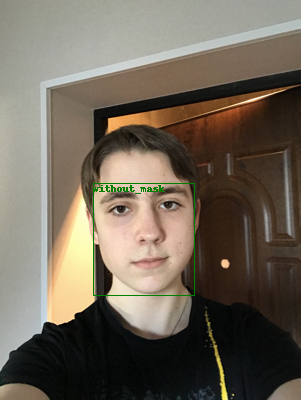

In [ ]:
# pick one image from the train set
img, target = dataset_train[22]
draw_bounding_boxes_testing(img, target)

### Setting up the Faster R-CNN Model

In [ ]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Nº of classes: background, with_mask, mask_weared_incorrect, without_mask and build model (faster r-cnn)
num_classes = 4 
model = build_model(num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
# Set Hyper-parameters

# Network params
params = [p for p in model.parameters() if p.requires_grad]

# Optimizers
# optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01)

# Learning Rate, lr decreases to half every 2 epochs 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Number of epochs to perform
epochs=20


### Train the model

In [ ]:
pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

In [ ]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

In [ ]:
from engine import train_one_epoch, evaluate
import utils
# Training method 1
for epoch in range(epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, loader_val, device=device)

In [ ]:
# Training method 2
model, loss_per_epoch = train_model(model,loader,optimizer,lr_scheduler,epochs,device)

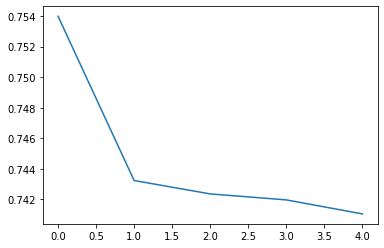

In [ ]:
plt.plot(loss_per_epoch)

### Saving the Model

In [ ]:
PATH = '/content/drive/MyDrive/FaceMaskDetection/model_colab_frcnn.pt'

In [ ]:
#torch.save(model.state_dict(), PATH)

### Prediction

In [ ]:
# Get saved model
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
img, target = dataset_validation[7]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]


In [ ]:
# Non max supression to reduce the number of bounding boxes
nms_prediction = apply_nms(prediction, iou_thresh=0.5, score_thresh=0.4)

400x225


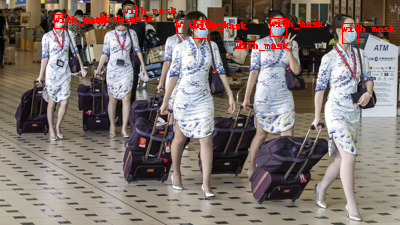

In [ ]:
# Draw bounding boxes
draw_bounding_boxes_testing(img.detach().cpu(), prediction= nms_prediction)

In [ ]:
labels = decode_labels(nms_prediction['labels'].detach().cpu().numpy())

In [ ]:
labels

['with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask']

# Next step: Evaluation Metrics